In [1]:
%pip install pandas numpy matplotlib seaborn scikit-learn xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
!{sys.executable} -m pip install pandas numpy matplotlib seaborn scikit-learn xgboost

In [3]:
import pandas as pd

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. CARGAR EL DATASET especificando que el separador es PUNTO Y COMA
# También eliminamos las columnas vacías del final con usecols
df = pd.read_csv('Proyecto_Oaxaca_Lluvia_FINAL.csv', sep=';')

# 2. Limpiar columnas vacías que se crean por los puntos y coma extra al final
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
# Eliminamos cualquier columna que no tenga nombre (las que salen como ;;;;)
df = df.dropna(axis=1, how='all')

# 3. Corregir los nombres de las columnas (quitar espacios si existen)
df.columns = df.columns.str.strip()

# 4. Convertir la fecha (ahora sí la va a encontrar bien)
if 'fecha_dt' in df.columns:
    # Usamos dayfirst=True porque en tu error se ve el formato 1/1/2011
    df['fecha_dt'] = pd.to_datetime(df['fecha_dt'], dayfirst=True)
    print("✅ Archivo cargado y fecha convertida correctamente.")
else:
    print("❌ No se encontró la columna 'fecha_dt'. Revisa el nombre.")

print("Total de registros cargados:", len(df))
print("\nColumnas finales:", df.columns.tolist())
display(df.head())

✅ Archivo cargado y fecha convertida correctamente.
Total de registros cargados: 858888

Columnas finales: ['Estado', 'Municipio', 'Estacion_ID', 'AÑO', 'Mes_Num', 'fecha_dt', 'RADIACION', 'TEMP_MEDIA', 'pm_media_estado', 'Precip', 'lluvia_binaria']


,Estado,Municipio,Estacion_ID,AÑO,Mes_Num,fecha_dt,RADIACION,TEMP_MEDIA,pm_media_estado,Precip,lluvia_binaria
0,Oaxaca,Asunción,Asunción,2011,1,2011-01-01,19.38,22.5,35.2,0.01,1
1,Oaxaca,Asunción,Asunción,2011,1,2011-01-01,19.38,22.5,35.2,0.01,1
2,Oaxaca,Asunción,Asunción,2011,1,2011-01-01,19.38,22.5,35.2,0.01,1
3,Oaxaca,Asunción,Asunción,2011,1,2011-01-01,19.38,22.5,35.2,0.01,1
4,Oaxaca,Asunción,Asunción,2011,1,2011-01-01,19.38,22.5,35.2,0.01,1


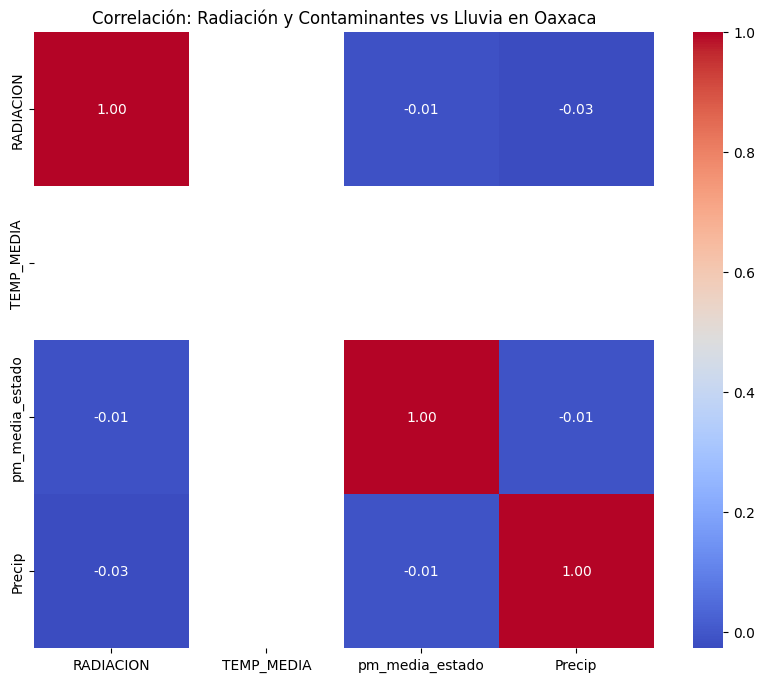

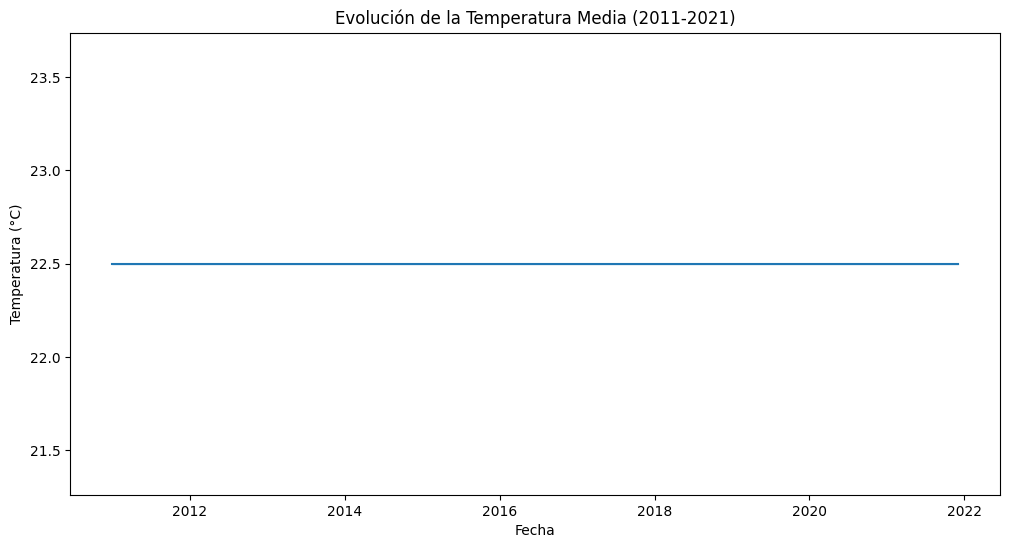

In [8]:
# --- CELDA DE EXPLORACIÓN (EDA) ---
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Matriz de Correlación
# Analizamos la relación entre Radiación, Contaminación y Precipitación
columnas_analisis = ['RADIACION', 'TEMP_MEDIA', 'pm_media_estado', 'Precip']
plt.figure(figsize=(10, 8))
sns.heatmap(df[columnas_analisis].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlación: Radiación y Contaminantes vs Lluvia en Oaxaca')
plt.show()

# 2. Visualización de Tendencia Temporal
# Graficamos la temperatura media a lo largo del tiempo
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='fecha_dt', y='TEMP_MEDIA')
plt.title('Evolución de la Temperatura Media (2011-2021)')
plt.xlabel('Fecha')
plt.ylabel('Temperatura (°C)')
plt.show()

In [9]:
# --- CELDA DE PREPROCESAMIENTO Y MODELOS ---
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix

# 1. Definir variables (X) y objetivo (y)
# Usamos las variables que analizamos en la gráfica de impacto
features = ['RADIACION', 'TEMP_MEDIA', 'pm_media_estado', 'AÑO', 'Mes_Num']
X = df[features]
y = df['lluvia_binaria']

# 2. Split Temporal (Train hasta 2019, Test 2020+)
train_mask = df['AÑO'] <= 2019
test_mask = df['AÑO'] >= 2020

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

# 3. Entrenamiento de 4 Modelos Compatibles
modelos = {
    "Regresión Logística": LogisticRegression(),
    "Árbol de Decisión": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "XGBoost": xgb.XGBClassifier(eval_metric='logloss')
}

print("Entrenando modelos... por favor espera.")
for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    print(f"✅ {nombre} entrenado.")

Entrenando modelos... por favor espera.
✅ Regresión Logística entrenado.
✅ Árbol de Decisión entrenado.
✅ Random Forest entrenado.
✅ XGBoost entrenado.


Generando métricas de evaluación...


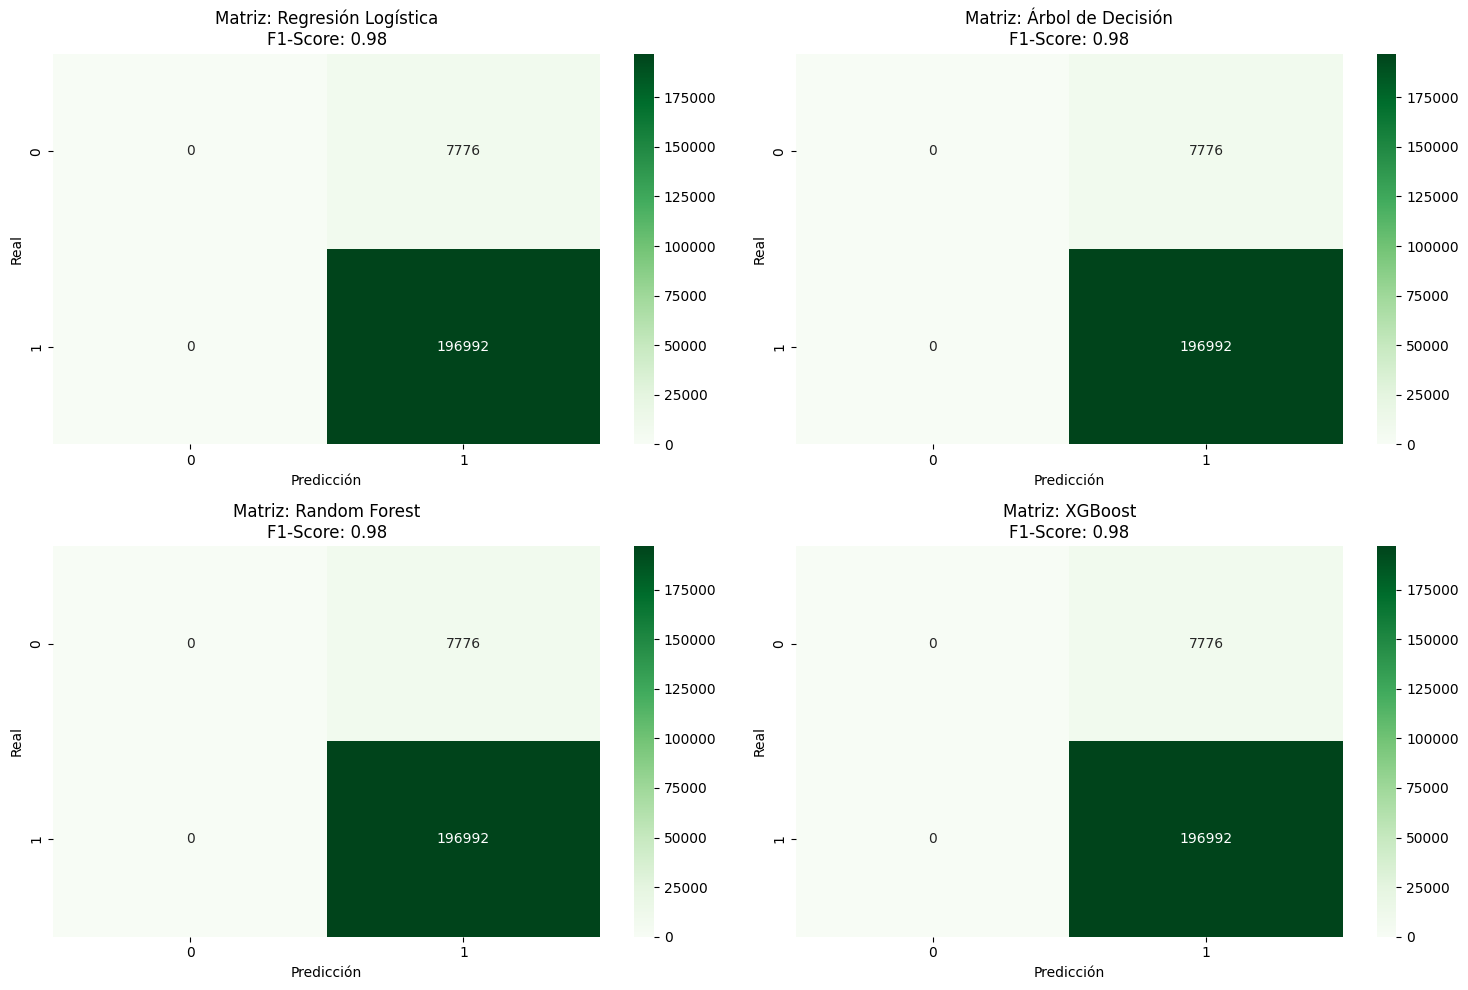

C:\Users\joana\AppData\Local\Temp\ipykernel_19480\1459056319.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=nombres, y=f1_scores, palette='magma')


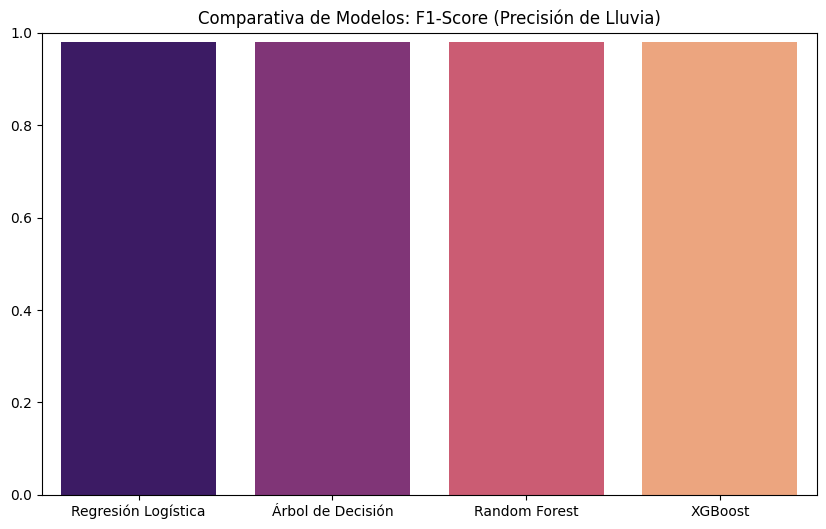

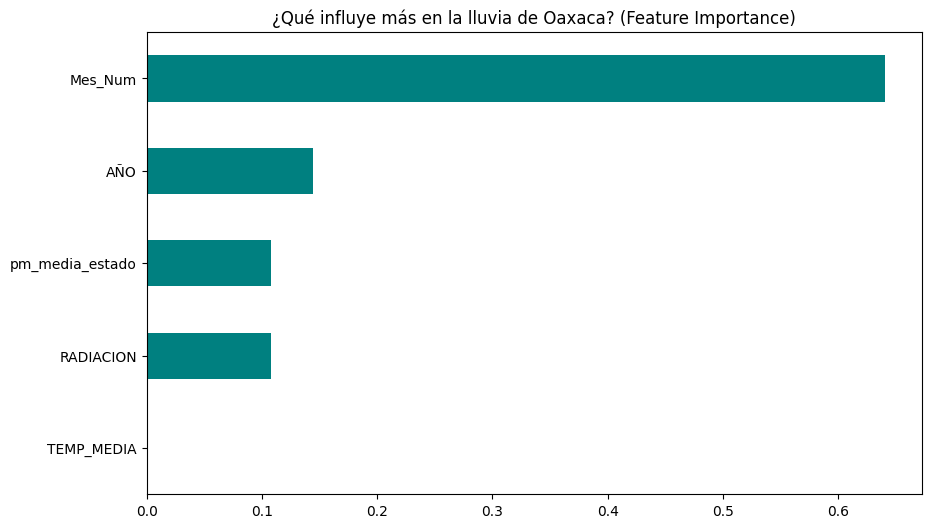

In [10]:
# --- CELDA DE EVALUACIÓN Y VISUALES ---
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# Listas para guardar métricas y comparar
nombres = []
f1_scores = []

print("Generando métricas de evaluación...")

# 1. Matriz de Confusión para cada modelo
plt.figure(figsize=(15, 10))
for i, (nombre, modelo) in enumerate(modelos.items(), 1):
    y_pred = modelo.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    nombres.append(nombre)
    f1_scores.append(f1)
    
    plt.subplot(2, 2, i)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
    plt.title(f'Matriz: {nombre}\nF1-Score: {f1:.2f}')
    plt.ylabel('Real')
    plt.xlabel('Predicción')

plt.tight_layout()
plt.show()

# 2. Gráfica de Barras: Comparativa F1-Score
plt.figure(figsize=(10, 6))
sns.barplot(x=nombres, y=f1_scores, palette='magma')
plt.title('Comparativa de Modelos: F1-Score (Precisión de Lluvia)')
plt.ylim(0, 1)
plt.show()

# 3. Feature Importance (Solo para Random Forest)
plt.figure(figsize=(10, 6))
importancia = pd.Series(modelos['Random Forest'].feature_importances_, index=features)
importancia.sort_values().plot(kind='barh', color='teal')
plt.title('¿Qué influye más en la lluvia de Oaxaca? (Feature Importance)')
plt.show()

In [ ]:
pip install folium


   ---- -----------------------------------  1/10 [urllib3]
   ---- -----------------------------------  1/10 [urllib3]
   -------- -------------------------------  2/10 [MarkupSafe]
   ------------ ---------------------------  3/10 [idna]
   ---------------- -----------------------  4/10 [charset_normalizer]
   ---------------- -----------------------  4/10 [charset_normalizer]
   ------------------------ ---------------  6/10 [requests]
   ------------------------ ---------------  6/10 [requests]
   ---------------------------- -----------  7/10 [jinja2]
   ---------------------------- -----------  7/10 [jinja2]
   -------------------------------- -------  8/10 [branca]
   ------------------------------------ ---  9/10 [folium]
   ------------------------------------ ---  9/10 [folium]
   ---------------------------------------- 10/10 [folium]

Note: you may need to restart the kernel to use updated packages.


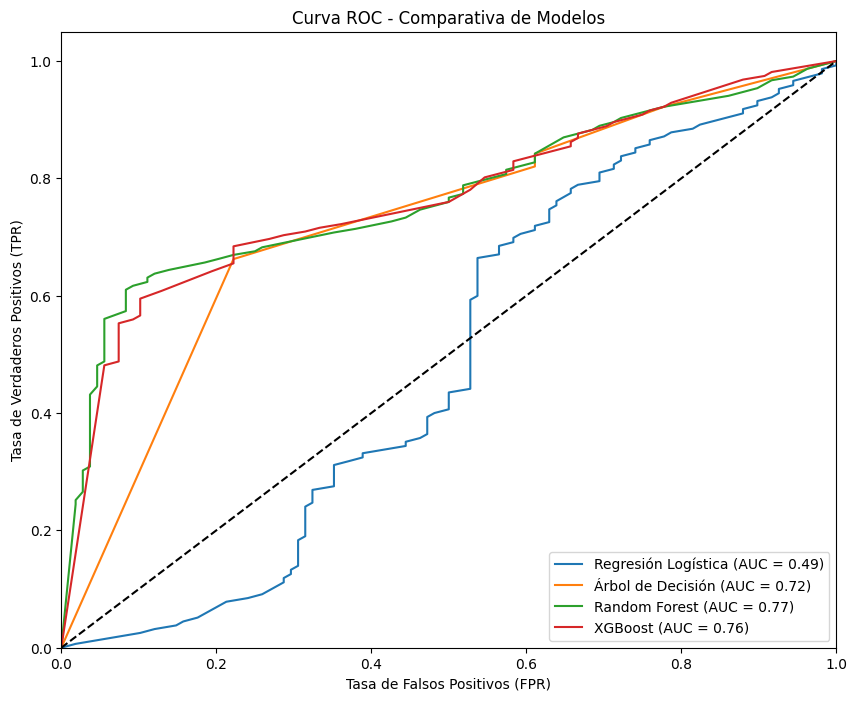

In [13]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))

for nombre, modelo in modelos.items():
    # Obtener probabilidades de predicción
    if hasattr(modelo, "predict_proba"):
        y_score = modelo.predict_proba(X_test)[:,1]
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{nombre} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--') # Línea diagonal de referencia
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Comparativa de Modelos')
plt.legend(loc="lower right")
plt.show()